# CP 12: Geant4 Exercises 3

## Part 1: Collider Experiments

In [1]:
# imports :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# reading data
truthData = pd.read_csv( "output_nt_Truth.csv", comment="#", \
names=[ "EventID", "Phi", "Theta", "Momentum" ] )

tracker1Data = pd.read_csv( "output_nt_Tracker1.csv", comment="#", \
names=[ "EventID", "Phi", "Theta" ] )

tracker2Data = pd.read_csv( "output_nt_Tracker2.csv", comment="#", \
names=[ "EventID", "Phi", "Theta" ] )

Data visualization in tables:

In [3]:
truthData.head()

,EventID,Phi,Theta,Momentum
0,0,-0.063847,2.422340,45.2024
1,0,3.077680,0.719255,45.4999
2,1,0.702142,2.213210,45.4999
3,1,-2.439450,0.928381,45.4999
4,2,1.446030,0.929328,45.4999


In [4]:
tracker1Data.head()

,EventID,Phi,Theta
0,1,-2.447670,0.928358
1,1,0.710358,2.213220
2,2,-1.703770,2.212250
3,2,1.454290,0.929340
4,3,0.335390,2.182440


In [5]:
tracker2Data.head()

,EventID,Phi,Theta
0,0,-2.066390,2.334350
1,1,-2.455900,0.928325
2,1,0.718557,2.213250
3,1,0.718558,2.213250
4,1,0.718534,2.213250


In [6]:
# checking that I have the correct number of events (yep)
max(truthData['EventID'])

999

### Using the event ID, print the number of true particles, layer one hits, and layer two hits in each event.

In [7]:
event_nums = np.arange(1000)

# initializing empty lists for things I want to calculate
event_truths = []
event_layer1_hits = []
event_layer2_hits = []

# looping through event numbers 1 to 1000, calculating the number of times an event
# number appears in all three datasets
for event in event_nums:
    event_truth = np.count_nonzero([truthData['EventID'] == event])
    event_truths.append(event_truth)
    
    event_layer1 = np.count_nonzero([tracker1Data['EventID'] == event])
    event_layer1_hits.append(event_layer1)
    
    event_layer2 = np.count_nonzero([tracker2Data['EventID'] == event])
    event_layer2_hits.append(event_layer2)

# compiling the counts into a dataframe
event_counts = pd.DataFrame({'True_Particles': event_truths, 
                             'Layer1_Hits': event_layer1_hits, 
                             'Layer2_Hits': event_layer2_hits
                            })

In [8]:
event_counts.head()

,True_Particles,Layer1_Hits,Layer2_Hits
0,2,0,1
1,2,2,7
2,2,2,2
3,2,2,6
4,2,34,2


## Part 2: Track Reconstruction

In [9]:
# reference code from the checkpoint document
import math

def pair_finding(l1_theta, l2_theta):
    # determine whether the two events of interest are the same particle
    if (math.fabs(l1_theta - l2_theta) < 0.0001 ):
        print("Pair found!")

### For each event, find all pairs of hits between layer 1 and layer 2.

In [25]:
# initializing empty lists for things I want to record
event_ids = []
l1_indices = []
l2_indices = []
l1_thetas = []
l2_thetas = []

events = np.arange(1000)

# looping through event IDs 1 to 1000, recording all of the information of
# reconstructed particles that meet the requirement of having a delta theta
# value less than 0.00004. I record the event ID, the indices of the particle
# in both tracker datasets, and the theta angles of the particle in both 
# datasets
for event in events:
    # decreasing the datasets to subsets by event ID reduces loop time significantly
    subset1 = tracker1Data[tracker1Data['EventID'] == event]
    subset2 = tracker2Data[tracker2Data['EventID'] == event]
    
    for ind1 in subset1.index:
        for ind2 in subset2.index:
            if abs(subset1['Theta'][ind1] - subset2['Theta'][ind2]) < 0.00004:
                event_ids.append(event)
                l1_indices.append(ind1)
                l2_indices.append(ind2)
                l1_thetas.append(subset1['Theta'][ind1])
                l2_thetas.append(subset2['Theta'][ind2])

# compiling the reconstructed particle information in a dataframe
pairs = pd.DataFrame({'EventID': event_ids, 
                      'l1_index': l1_indices,
                      'l2_index': l2_indices,
                      'l1_theta': l1_thetas,
                      'l2_theta': l2_thetas
                     })

In [26]:
pairs.head()

,EventID,l1_index,l2_index,l1_theta,l2_theta
0,1,0,1,0.928358,0.928325
1,1,1,2,2.213220,2.213250
2,1,1,3,2.213220,2.213250
3,1,1,4,2.213220,2.213250
4,1,1,5,2.213220,2.213250


### For each pair of tracker hits, assume they come from a single particle and calcuate its momentum.

In [27]:
def calc_sagitta(phi1, phi2, r1):
    # a function to calculate sagitta
    delta_phi = abs(phi1 - phi2)
    sagitta = np.sin(delta_phi)*r1
    return sagitta

# Various equations
# R = (L^2) / (8*s)
# p_T = 0.3*B*R
# p = p_T/sin(theta)

def calc_momentum(L, sagitta, B, theta):
    # a function to calculate total momentum
    R = (L**2) / (8*sagitta)
    p_T = 0.3*B*R
    p = p_T / np.sin(theta)
    return p

In [28]:
# radii of the two layers (L = radius of layer 2; r1 = radius of layer 1) and magnetic field B
L = 8
r1 = 4
B = 0.5

# initializing an empty list to record calculated momenta
momenta = []

# looping through every reconstructed particle in pairs dataframe, using the functions
# in the previous cell to calculate total momentum. I chose just to use the theta value
# in the tracker1 dataset, since it is essentially equal to the theta in tracker2 data
for item in pairs.index:
    index_1 = pairs['l1_index'][item]
    index_2 = pairs['l2_index'][item]
    
    s = calc_sagitta(tracker1Data['Phi'][index_1], tracker2Data['Phi'][index_2], r1)
    p = calc_momentum(L, s, B, pairs['l1_theta'][item])
    
    momenta.append(p)

# concatenating the momentum data and the pairs dataframe
momenta_df = pd.DataFrame({'momentum': momenta})
pairs = pd.concat([pairs, momenta_df], axis=1)

In [29]:
pairs.head()

,EventID,l1_index,l2_index,l1_theta,l2_theta,momentum
0,1,0,1,0.928358,0.928325,45.529255
1,1,1,2,2.213220,2.213250,45.700894
2,1,1,3,2.213220,2.213250,45.695321
3,1,1,4,2.213220,2.213250,45.829453
4,1,1,5,2.213220,2.213250,45.924941


### Find the momentum resolution of our experiment. Plot a 1D histogram to show the distribution for all reconstructed particles.


In [14]:
# making a list of event IDs that appear in the pairs dataframe
selected_truth_ids = [i for i in truthData['EventID'] if i in pairs['EventID'].values]
truth_ids = [*set(selected_truth_ids)]        

In [15]:
# initializing an empty list for calculating momentum resolution values
calc_val = []

# looping through every reconstructed particle in pairs, choosing the best corresponding true momentum value
# in the true dataset by checking which theta value is closer to the reconstructed particle's
for particle in pairs.index:
    ID = pairs['EventID'][particle]
    truth_selection = truthData[truthData['EventID'] == ID]
    ts_inds = truth_selection.index
    
    if abs(truth_selection['Theta'][ts_inds[0]] - pairs['l1_theta'][particle]) < \
    abs(truth_selection['Theta'][ts_inds[1]] - pairs['l1_theta'][particle]):
        diff = (pairs['momentum'][particle] - truth_selection['Momentum'][ts_inds[0]])/(truth_selection['Momentum'][ts_inds[0]])
        calc_val.append(diff)
            
    else:
        diff = (pairs['momentum'][particle] - truth_selection['Momentum'][ts_inds[1]])/(truth_selection['Momentum'][ts_inds[1]])
        calc_val.append(diff)                                                                

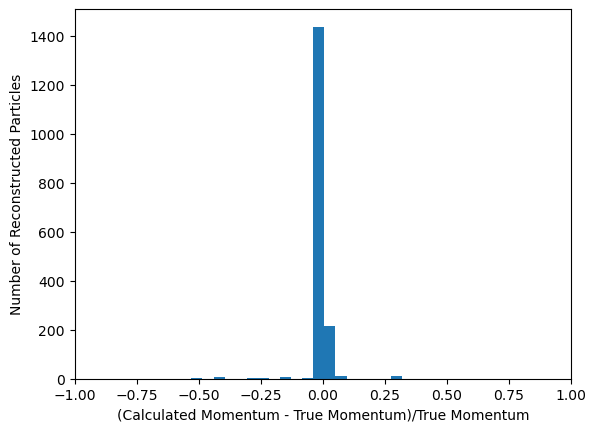

In [16]:
# plotting momentum resolution distribution
plt.figure()
plt.hist(calc_val, bins=75)
plt.xlim([-1, 1])
plt.xlabel('(Calculated Momentum - True Momentum)/True Momentum')
plt.ylabel('Number of Reconstructed Particles')
plt.show()

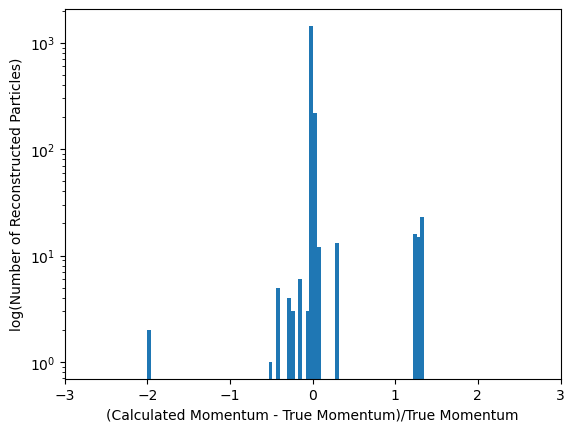

In [17]:
# plotting momentum resolution distribution with a logscale axis
plt.figure()
plt.hist(calc_val, bins=75)
plt.xlim([-3, 3])
plt.yscale('log')
plt.xlabel('(Calculated Momentum - True Momentum)/True Momentum')
plt.ylabel('log(Number of Reconstructed Particles)')
plt.show()

The two charts show the distribution of momentum resolution, the first chart with regular axes, and the second chart with a logscale y axis. The average momentum resolution of all the reconstructed particles is:

In [18]:
np.mean(calc_val)

0.0374502142594683

## Part 3: Physics Analysis

### Plot the total mass distribution. What was the original particle? Compare your results to the PDG values for mass and width.

In [19]:
# adding a delta theta column to the pairs dataframe
deltheta_vals = abs(pairs['l1_theta'] - pairs['l2_theta'])
delta_theta = pd.DataFrame({'delta_theta': deltheta_vals})
pairs = pd.concat([pairs, delta_theta], axis=1)

In [20]:
# sorting the reconstructed particle dataset by increasing delta theta
sorted_particles = pairs.sort_values(by=['delta_theta', 'EventID'])
sorted_particles.head()

,EventID,l1_index,l2_index,l1_theta,l2_theta,momentum,delta_theta
15,6,42,20,1.62832,1.62832,45.738081,0.0
16,6,43,20,1.62832,1.62832,45.738081,0.0
23,13,62,28,1.46102,1.46102,45.047613,0.0
26,17,78,46,1.84535,1.84535,45.767361,0.0
27,18,79,47,2.29918,2.29918,45.322956,0.0


In [21]:
events = np.arange(1000)

# creating an empty list to store summent momentum values
summed_momenta = []

# looping over reconstructed particle event IDs and choosing the two reconstructions that 
# have the smallest delta theta then summing their momenta to find total reconstructed 
# energy
for event in truth_ids:
    subset = sorted_particles[sorted_particles['EventID'] == event]
    num = len(subset)
    subset = subset.set_index(np.arange(num))

    if num > 1:
        sum_p = subset['momentum'][0] + subset['momentum'][1]
        summed_momenta.append(sum_p)

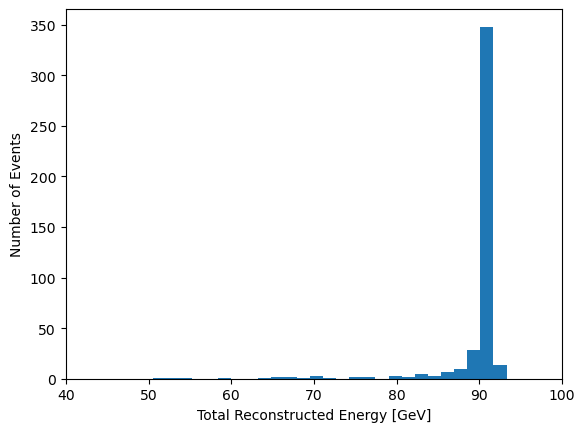

In [22]:
# plotting mass distribution
plt.figure()
plt.hist(summed_momenta, bins=75)
plt.xlim([40, 100])
plt.xlabel('Total Reconstructed Energy [GeV]')
plt.ylabel('Number of Events')
plt.show()

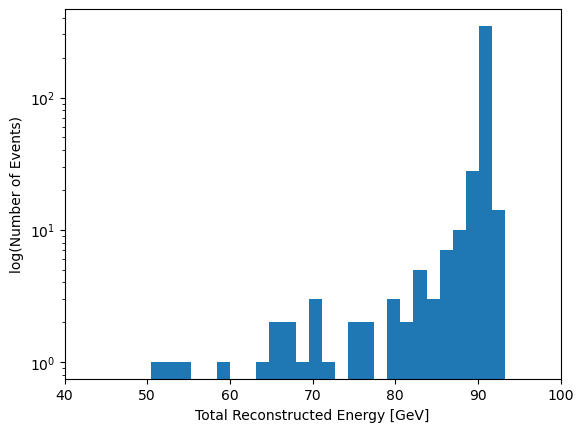

In [23]:
# plotting mass distribution with logscale y axis
plt.figure()
plt.hist(summed_momenta, bins=75)
plt.xlim([40, 100])
plt.xlabel('Total Reconstructed Energy [GeV]')
plt.ylabel('log(Number of Events)')
plt.yscale('log')
plt.show()

In [24]:
# finding the decaying particle's mass and decay width
mass = np.mean(summed_momenta)
width = np.std(summed_momenta)

print('The particle has a mass of ', mass, 'GeV and a decay width of ', width, 'GeV')

The particle has a mass of  89.21273473895769 GeV and a decay width of  8.145595719737813 GeV


This corresponds most closely to the mass of the Z boson, which is 91.2 GeV and has a decay width of 2.5 GeV. The reconstructed data is shifted slightly in the negative x direction and has a wider peak.